# Import Packages and Classifiers

In [14]:
#!pip install --user scikit-learn

In [15]:
#!pip install --user matplotlib

In [16]:
#!pip install --user pandas

In [17]:
#!pip install --user numpy

In [18]:
#!pip install --user seaborn

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import accuracy_score
import time

from sklearn.model_selection import learning_curve
import pandas as pd 
import numpy as np  


https://scikit-learn.org/stable/modules/cross_validation.html

# Import Data 

In [35]:
hr_data = pd.read_csv("hr_data.csv")
bank_data = pd.read_csv("bank-marketing.csv")

# First Dataset 
https://www.kaggle.com/dhirajnirne/bank-marketing

## Prep Data for Modeling 

In [36]:
bank_data.columns

Index(['age', 'age group', 'eligible', 'job', 'salary', 'marital', 'education',
       'marital-education', 'targeted', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'response'],
      dtype='object')

In [37]:
categorical_cols = ['age group', 'eligible', 'job', 'marital', 'education',
       'marital-education', 'targeted', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'poutcome']

for i in categorical_cols: 
    le = preprocessing.LabelEncoder()
    le.fit(bank_data[i].unique())
    bank_data[i] = le.transform(bank_data[i])

In [38]:
target = 'response'
cols = ['age', 'age group', 'eligible', 'job', 'salary', 'marital', 'education',
       'marital-education', 'targeted', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome']

#splitn into training and testing data sets
train, test = train_test_split(bank_data, test_size=0.2)

In [39]:
train_sizes = np.arange(1, len(train), 1500).tolist()#.append(len(train))
train_sizes.append(len(train)-1)


## Decision Tree with Pruning 
https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

https://www.analyticsvidhya.com/blog/2020/10/cost-complexity-pruning-decision-trees/

In [40]:
decision_tree = DecisionTreeClassifier(random_state=0)
path = decision_tree.cost_complexity_pruning_path(train[cols], train[target])
alphas, impurities = path.ccp_alphas, path.impurities


In [41]:
from sklearn.metrics import accuracy_score
accuracy_train, accuracy_test = [], []
max_score = 0 
max_score_alpha = 0

for i in alphas:
    
    tree = DecisionTreeClassifier(ccp_alpha = i)
    
    tree.fit(train[cols], train[target])
    y_train_pred = tree.predict(train[cols])
    y_test_pred = tree.predict(test[cols])
    
    accuracy_train.append(accuracy_score(train[target], y_train_pred))
    accuracy_test.append(accuracy_score(test[target], y_test_pred))
    
    #use the alpha that has the max score on the test set
    max_score_alpha = i if max_score < accuracy_score(test[target], y_test_pred) else max_score_alpha  
    max_score = max_score if max_score < accuracy_score(test[target], y_test_pred) else max_score  


<AxesSubplot:>

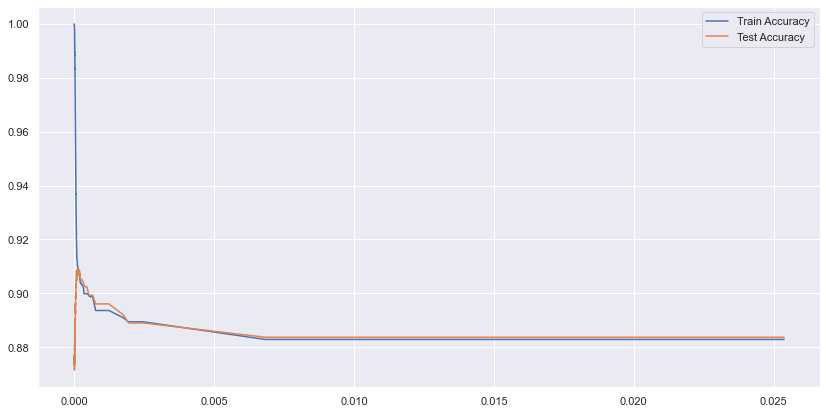

In [42]:
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y = accuracy_train, x = alphas, label = "Train Accuracy")
sns.lineplot(y = accuracy_test, x = alphas, label = "Test Accuracy")

In [43]:
start_time = time.time()
final_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=max_score_alpha)
final_tree.fit(train[cols], train[target])
final_tree_runtime = time.time() - start_time
final_tree_training_error = 1 - accuracy_score(train[target], final_tree.predict(train[cols]))
final_tree_error = 1 - accuracy_score(test[target], final_tree.predict(test[cols]))

In [44]:
final_tree_row = pd.DataFrame(['Decision Tree', final_tree_training_error, final_tree_error, final_tree_runtime] ).T

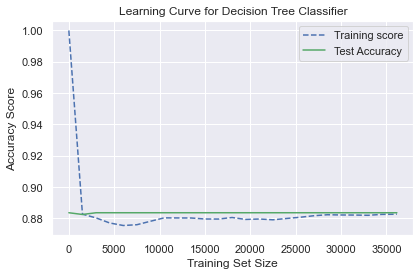

In [45]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    train_data_subset = train.head(i)
    classifier  = DecisionTreeClassifier(random_state=0, ccp_alpha=max_score_alpha)
    classifier.fit(train_data_subset[cols], train_data_subset[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes, train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes, test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for Decision Tree Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Neural Network
https://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [46]:
start_time = time.time()
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

nn.fit(train[cols], train[target])
nn_runtime = time.time() - start_time 

nn_training_error = 1 - accuracy_score(train[target], nn.predict(train[cols]))
nn_error = 1 - accuracy_score(test[target], nn.predict(test[cols]))

nn_row = pd.DataFrame(['Neural Network', nn_training_error, nn_error, nn_runtime] ).T

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABN

/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/nicole/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABN

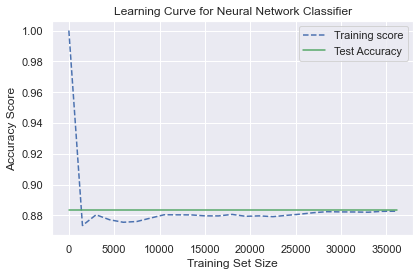

In [47]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    train_data_subset = train.head(i)
    classifier  = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
    classifier.fit(train_data_subset[cols], train_data_subset[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes, train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes, test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for Neural Network Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Boosting 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#:~:text=An%20AdaBoost%20%5B1%5D%20classifier%20is,focus%20more%20on%20difficult%20cases.

In [48]:
start_time = time.time()

ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(train[cols], train[target])
ada_runtime = time.time() - start_time 

ada_training_error = 1 - accuracy_score(train[target], ada.predict(train[cols]))
ada_error = 1 - accuracy_score(test[target], ada.predict(test[cols]))

ada_row = pd.DataFrame(['Ada Boost', ada_training_error, ada_error, ada_runtime] ).T

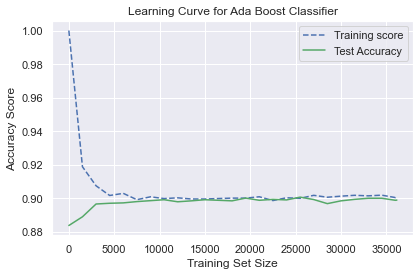

In [49]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    train_data_subset = train.head(i)
    classifier  = AdaBoostClassifier(n_estimators=100, random_state=0)
    classifier.fit(train_data_subset[cols], train_data_subset[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes, train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes, test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for Ada Boost Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Support Vector Machines 
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py

In [50]:
start_time = time.time()

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(train[cols], train[target])
clf_runtime = time.time() - start_time 

clf_training_error = 1 - accuracy_score(train[target], clf.predict(train[cols]))
clf_error = 1 - accuracy_score(test[target], clf.predict(test[cols]))

clf_row = pd.DataFrame(['Support Vector Machine', clf_training_error, clf_error, clf_runtime] ).T

In [51]:
clf_row 
#Cross validation doesn't make sense hear 

,0,1,2,3
0,Support Vector Machine,0.092181,0.099082,16.218115


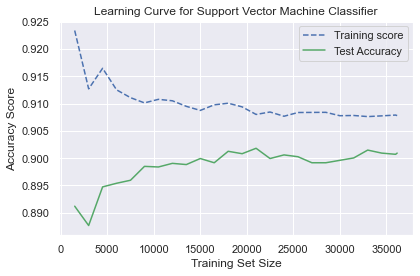

In [52]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1: 
        train_data_subset = train.head(i)
        classifier  = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for Support Vector Machine Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## K Nearest Neighbors
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


In [60]:
from sklearn.model_selection import GridSearchCV
#https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/
# define the parameter values that should be searched
# for python 2, k_range = range(1, 31)
k_range = list(range(1, 10))

# create a parameter grid: map the parameter names to the values that should be searched
# simply a python dictionary
# key: parameter name
# value: list of values that should be searched for that parameter
# single key-value pair for param_grid
param_grid = [{'n_neighbors': k_range,
         'weights': ['uniform', 'distance']}]

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(train[cols], train[target])

# plot the results
# this is identical to the one we generated above

grid_mean_scores = grid.cv_results_.get('mean_test_score')

plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [ ]:
start_time = time.time()

neigh = KNeighborsClassifier(n_neighbors=grid.best_params_.get('n_neighbors'))
neigh.fit(train[cols], train[target])
neigh_runtime = time.time() - start_time 

neigh_training_error = 1 - accuracy_score(train[target], neigh.predict(train[cols]))
neigh_error = 1 - accuracy_score(test[target], neigh.predict(test[cols]))

neigh_row = pd.DataFrame(['K Nearest Neighbor', neigh_training_error, neigh_error, neigh_runtime]).T 

In [ ]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1:
        train_data_subset = train.head(i)
        classifier  = KNeighborsClassifier(n_neighbors=grid.best_params_.get('n_neighbors'))
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

num_of_neighbors = grid.best_params_.get('n_neighbors')
plt.title(f"Learning Curve for K Nearest Neighbor {num_of_neighbors} Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
final_df = neigh_row.append(clf_row).append(ada_row).append(nn_row).append(final_tree_row)
final_df.columns = ['Classifier Name', 'Training Error', 'Testing Error', 'Training Time']
final_df

# Second Dataset   

https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists?select=aug_train.csv

## Prep Data for Modeling 

In [ ]:
hr_data.columns

In [ ]:
categorical_cols = ['city', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job']

for i in categorical_cols: 
    le = preprocessing.LabelEncoder()
    le.fit(hr_data[i].unique())
    hr_data[i] = le.transform(hr_data[i])



In [ ]:
target = 'target'
cols = ['city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours']

#splitn into training and testing data sets
train, test = train_test_split(hr_data, test_size=0.3)
train_sizes = np.arange(1, len(train), 1000).tolist()
train_sizes.append(len(train)-1)

## Decision Tree with Pruning 

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=0)
path = decision_tree.cost_complexity_pruning_path(train[cols], train[target])
alphas, impurities = path.ccp_alphas, path.impurities
accuracy_train, accuracy_test = [], []
max_score = 0 
max_score_alpha = 0

for i in alphas:
    
    tree = DecisionTreeClassifier(ccp_alpha = i)
    
    tree.fit(train[cols], train[target])
    y_train_pred = tree.predict(train[cols])
    y_test_pred = tree.predict(test[cols])
    
    accuracy_train.append(accuracy_score(train[target], y_train_pred))
    accuracy_test.append(accuracy_score(test[target], y_test_pred))
    
    #use the alpha that has the max score on the test set
    max_score_alpha = i if max_score < accuracy_score(test[target], y_test_pred) else max_score_alpha  
    max_score = max_score if max_score < accuracy_score(test[target], y_test_pred) else max_score  


In [ ]:
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y = accuracy_train, x = alphas, label = "Train Accuracy")
sns.lineplot(y = accuracy_test, x = alphas, label = "Test Accuracy")

In [ ]:
start_time = time.time()
final_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=max_score_alpha)
final_tree.fit(train[cols], train[target])
final_tree_runtime = time.time() - start_time
final_tree_training_error = 1 - accuracy_score(train[target], final_tree.predict(train[cols]))
final_tree_error = 1 - accuracy_score(test[target], final_tree.predict(test[cols]))

final_tree_row = pd.DataFrame(['Decision Tree', final_tree_training_error, final_tree_error, final_tree_runtime] ).T

In [ ]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    train_data_subset = train.head(i)
    classifier  = DecisionTreeClassifier(random_state=0, ccp_alpha=max_score_alpha)
    classifier.fit(train_data_subset[cols], train_data_subset[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes, train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes, test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for Decision Tree Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Neural Network

In [ ]:
start_time = time.time()
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

nn.fit(train[cols], train[target])
nn_runtime = time.time() - start_time 

nn_training_error = 1 - accuracy_score(train[target], nn.predict(train[cols]))
nn_error = 1 - accuracy_score(test[target], nn.predict(test[cols]))

nn_row = pd.DataFrame(['Neural Network', nn_training_error, nn_error, nn_runtime] ).T

In [ ]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    train_data_subset = train.head(i)
    classifier  = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
    classifier.fit(train_data_subset[cols], train_data_subset[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes, train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes, test_accuracy, color="g", label="Test Accuracy")


plt.title("Learning Curve for Neural Network Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Boosting 

In [ ]:
start_time = time.time()

ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(train[cols], train[target])
ada_runtime = time.time() - start_time 

ada_training_error = 1 - accuracy_score(train[target], ada.predict(train[cols]))
ada_error = 1 - accuracy_score(test[target], ada.predict(test[cols]))

ada_row = pd.DataFrame(['Ada Boost', ada_training_error, ada_error, ada_runtime] ).T

In [ ]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    train_data_subset = train.head(i)
    classifier  = AdaBoostClassifier(n_estimators=100, random_state=0)
    classifier.fit(train_data_subset[cols], train_data_subset[target])
    #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
    test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes, train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes, test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for Ada Boost Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Support Vector Machines 

In [ ]:
start_time = time.time()

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(train[cols], train[target])
clf_runtime = time.time() - start_time 

clf_training_error = 1 - accuracy_score(train[target], clf.predict(train[cols]))
clf_error = 1 - accuracy_score(test[target], clf.predict(test[cols]))

clf_row = pd.DataFrame(['Support Vector Machine', clf_training_error, clf_error, clf_runtime] ).T

In [ ]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1: 
        train_data_subset = train.head(i)
        classifier  = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

plt.title("Learning Curve for Support Vector Machine Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## K Nearest Neighbors

In [ ]:
from sklearn.model_selection import GridSearchCV
#https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/
# define the parameter values that should be searched
# for python 2, k_range = range(1, 31)
k_range = list(range(1, 10))

# create a parameter grid: map the parameter names to the values that should be searched
# simply a python dictionary
# key: parameter name
# value: list of values that should be searched for that parameter
# single key-value pair for param_grid
param_grid = [{'n_neighbors': k_range,
         'weights': ['uniform', 'distance']}]

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(train[cols], train[target])

# plot the results
# this is identical to the one we generated above

grid_mean_scores = grid.cv_results_.get('mean_test_score')

plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [ ]:
start_time = time.time()

neigh = KNeighborsClassifier(n_neighbors=grid.best_params_.get('n_neighbors'))
neigh.fit(train[cols], train[target])
neigh_runtime = time.time() - start_time 

neigh_training_error = 1 - accuracy_score(train[target], neigh.predict(train[cols]))
neigh_error = 1 - accuracy_score(test[target], neigh.predict(test[cols]))

neigh_row = pd.DataFrame(['K Nearest Neighbor', neigh_training_error, neigh_error, neigh_runtime]).T 

In [ ]:
test_accuracy = []
train_accuracy = []
for i in train_sizes:
    if i > 1: 
        train_data_subset = train.head(i)
        classifier  = KNeighborsClassifier(n_neighbors=3)
        classifier.fit(train_data_subset[cols], train_data_subset[target])
        #print(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        train_accuracy.append(accuracy_score(train_data_subset[target], classifier.predict(train_data_subset[cols])))
        test_accuracy.append(accuracy_score(test[target], classifier.predict(test[cols])))

    
plt.plot(train_sizes[1:], train_accuracy, '--', color="b",  label="Training score")
plt.plot(train_sizes[1:], test_accuracy, color="g", label="Test Accuracy")

num_of_neighbors = grid.best_params_.get('n_neighbors')
plt.title(f"Learning Curve for K Nearest Neighbor {num_of_neighbors} Classifier")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score") 
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
final_df = neigh_row.append(clf_row).append(ada_row).append(nn_row).append(final_tree_row)
final_df.columns = ['Classifier Name', 'Training Error', 'Testing Error', 'Training Time']

In [ ]:
final_df